Data analysis of Severe Accute Respiratoy Sindrome - Sindrome Respiratória Aguda  Grave (in portuguese) provided by Unique System of health (Sistema Único de Saúde - SUS)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from IPython.display import display


## 1 - Questions to answer:

1.1 How is the correlation between Covid's diagnosis and symptom descriptions?<br>
1.2 Is Covid more easily detectable in patients with pre-existing diseases?<br>
1.3 What is the accuracy and recall of antigen sorologic and PCR tests?<br>
1.4 Are these metrics (accuracy and recall) the same in the Brazilian states?

## 2 - Database availability

To answer the questions asked it is necessary a database with information about the diagnosis, symptoms, comorbidities and applied tests in hospitals. In Brazil, the health system administered by the government is called the Unified Health System and maintains databases available at opendatasus.saude.gov.br. In particular, we are focused on the SRAG database (https://opendatasus.saude.gov.br/dataset/bd-srag-2020), describing notifications about severe respiratory syndrome caused by the Influenza virus and since 2019 we have also Covid, caused by this Chinese virus.

The database version I'm using is from February 22th. The files have been updated since I downloaded my copy.

## 3  - Data cleaning

Starting to look to the data, is necessary the database dictionary to identify the fields (available [here](https://opendatasus.saude.gov.br/dataset/bd-srag-2020/resource/8f571374-c555-4ec0-8e44-00b1e8b11c25))

The Figure 1 shows the histogram of all notifications in grey, the Flu notifications appear in the beginning of the year and some points in green, the majority of notifications are confirmed Covid-19 cases (in red) and the blue line represents undefined cases.

In [ ]:
#Leitura dos dados
!wget 'https://s3-sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/2020/INFLUD-22-02-2021.csv'

dados = pd.read_csv('/content/INFLUD-22-02-2021.csv',sep=";", encoding='cp860', 
                    header=0,infer_datetime_format=True,low_memory=False)


--2021-05-05 22:54:49--  https://s3-sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/2020/INFLUD-22-02-2021.csv
Resolving s3-sa-east-1.amazonaws.com (s3-sa-east-1.amazonaws.com)... 52.95.163.66
Connecting to s3-sa-east-1.amazonaws.com (s3-sa-east-1.amazonaws.com)|52.95.163.66|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 642931906 (613M) [text/csv]
Saving to: ‘INFLUD-22-02-2021.csv’

INFLUD-22-02-2021.c 100%[===================>] 613.15M  23.6MB/s    in 36s     

2021-05-05 22:55:25 (17.2 MB/s) - ‘INFLUD-22-02-2021.csv’ saved [642931906/642931906]



This dataset contains 1181227 records and 154 attributes.
The data begins on 2019-12-29 00:00:00 and ends on 2021-02-21 00:00:00.
There is 2721 Flu notifications.
There is 409097 undefined notifications.
There is 676670 Covid-19 notifications.


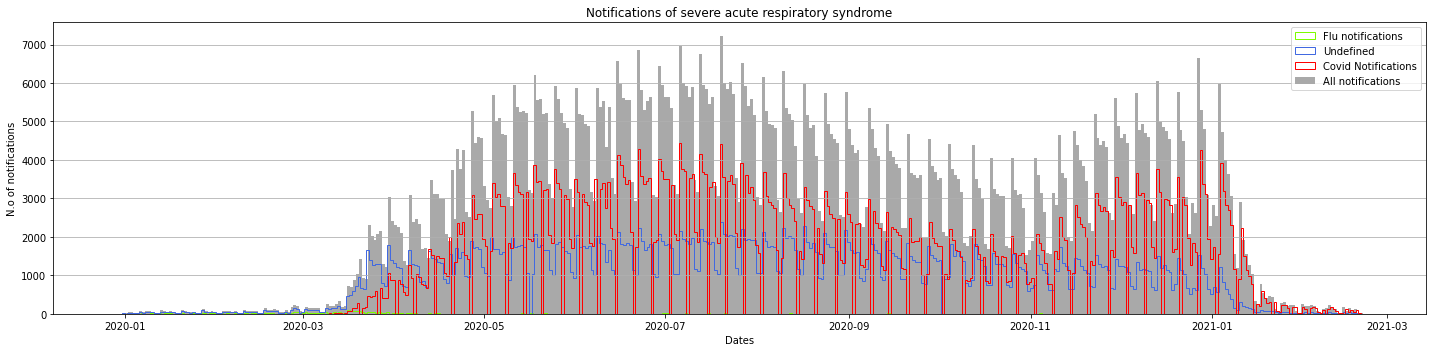

In [ ]:
dados['DT_NOTIFIC'] = pd.to_datetime(dados['DT_NOTIFIC'],format='%d/%m/%Y')

#Exploratory analizes
size_dados=dados.shape

min_day=dados.DT_NOTIFIC.min()
max_day=dados.DT_NOTIFIC.max()
days = dados.groupby('DT_NOTIFIC').DT_NOTIFIC.count().index

print('This dataset contains {} records and {} attributes.'.
      format(size_dados[0],size_dados[1]))
print('The data begins on {} and ends on {}.'.
      format(min_day,max_day))
print("There is {} Flu notifications.".format(dados\
                                              [dados.CLASSI_FIN==1].\
                                              DT_NOTIFIC.count()))
print("There is {} undefined notifications.".format(dados\
                                                    [dados.CLASSI_FIN==4].\
                                                    DT_NOTIFIC.count()))
print("There is {} Covid-19 notifications.".format(dados\
                                                    [dados.CLASSI_FIN==5].\
                                                    DT_NOTIFIC.count()))

plt.figure(figsize=((20,5)))

dados.DT_NOTIFIC.hist(bins=len(days), color='darkgrey')
dados[dados.CLASSI_FIN==1].DT_NOTIFIC.hist(bins=len(days), histtype='step',
                                                     color='lawngreen')
dados[dados.CLASSI_FIN==4].DT_NOTIFIC.hist(bins=len(days), histtype='step',
                                                     color='royalblue')
dados[dados.CLASSI_FIN==5].DT_NOTIFIC.hist(bins=len(days), histtype='step',
                                                     color='red')
plt.legend(['Flu notifications','Undefined',
            'Covid Notifications','All notifications'])
plt.title('Notifications of severe acute respiratory syndrome')
plt.xlabel('Dates')
plt.ylabel('N.o of notifications')
plt.grid(axis='x')
    
plt.tight_layout()
plt.show()


In a simple evaluation, it was easy to notice the presence of information in the description fields, where the data entry is not a checkbox, but a text with symptoms, diseases and relevant information. The searches in the fields OUTROS_DES and MORB_DESC provided us with a lot of information, adding symptoms and diseases not present in the original fields.

In [ ]:
#Dictionary of columns and synonyms of symptoms + headache, body pain and coryza
symptoms={'FEBRE':'FEBRE','TOSSE':['PIGARRO','TOSSE'],'DISPNEIA':'DISPNEIA',
            'DESC_RESP':'RESPIRATORIO','SATURACAO':'SATURACAO',
            'DIARREIA':['DIARREIA','CAGANEIRA'],'VOMITO':'VOMITO',
            'DOR_ABD':['ABDOMEN','ABDO','ABDOMINAL','ABD'],
            'FADIGA':['FADIGA','PROSTRACAO'],'PERD_OLFT':['OLFATO','CHEIRO'],
            'PERD_PALA':['GOSTO','PALADAR','AGEUSIA'],
            'DOR_CABECA':['CABECA','CEFALEIA'],'DOR_CORPO':'CORPO',
           'CORIZA':['CORIZA','SECRECAO','CATARRO'],'OUTRO_SIN':'OUTRO_SIN'}

#Creating additional symptoms columns
for sintoma in ['DOR_CORPO','DOR_CABECA','CORIZA']:
    linhas,colunas=dados.shape
    dados.insert(colunas,sintoma,np.full(linhas,np.nan))

#Dictionary of columns and synonyms of comorbidities
comorbidity={'PUERPERA':['PUERPERA','PARTURIENTE','PARTO'],
             'CARDIOPATI':['CARDIOPATIA','MIALGIA','PEITO','MIALGIAS'],
             'HEMATOLOGI':'HEMATOLOGI','SIND_DOWN':['DOWN','SIND_DOWN'],
            'HEPATICA':'HEPATICA','ASMA':['ASMA','BRONQUIOLITE'],
             'DIABETES':'DIABETES','NEUROLOGIC':'NEUROLOGIC',
             'PNEUMOPATI':'PNEUMOPATI','IMUNODEPRE':['DEPRESSAO','IMUNODEPRE'],
             'RENAL':['RENAL','RINS','RIM'],'OBESIDADE':'OBESIDADE',
             'OUT_MORBI':['OUTRA','OUT_MORBI']}

def search_words(database, search, join, words):
    ''' this function perform a search for word in the column search of database\n
     and add the results with column join, a series with the original information.\n
    The database will be update during inside this function. \n
    Inputs:   database - dataframe to perform the search \n
              search - string of column where the search take place \n
              join - string of column to receive update \n
              words - strings or list of strings to search \n
    Outputs:  
    '''

    num_initial = database[database[join]==1].shape[0]

    result = database[join].copy()   #Copy input column
    #Check the type of variable
    if type(words) != list:
        words = [words]
    #Substitution of separator between words
    temp=database[search].replace({',':'', '/':' ', '\+':' ', '-':' ', '=':' ' },
                                  regex=True).str.split(expand=True)
    #Terms search
    result_search = temp.isin(words).sum(axis=1)
    #Index
    index = result_search[result_search==1].index.tolist()
    #Inserting 1 where found the word
    result.iloc[index] = 1

    #update the column
    database[join] = result

    num_final = database[database[join]==1].shape[0]

    print('The search for synonyms of {0:11s} found {1:5d} occurences and\
       added {2:5.2f}% to the records'.format(join,
                                              num_final,
                                              100*(num_final-num_initial)/(1+num_initial)))
    
    #Update the database
    database[join]=result

#Searching the symptoms in OUTROS_DES column
for sintoma in symptoms:
    search_words(dados,'OUTRO_DES',sintoma,symptoms[sintoma])

#Searching for comorbidities in MORB_DESC
for comorbidade in comorbidity:
    search_words(dados,'MORB_DESC',comorbidade,comorbidity[comorbidade])

#Searching for comorbidities in OUTRO_DES
for comorbidade in comorbidity:
    search_words(dados,'OUTRO_DES',comorbidade,comorbidity[comorbidade])

#Searching for PCR results in DS_PCR_OUT, DS_AN_OUT
Covid_Sinonym=['COVID','COVID-19','CORONAVIRUS','COVID19','SAR','SARS','SRAG']
CampoBusca=['DS_PCR_OUT','DS_AN_OUT']
CampoRes=['AN_SARS2','PCR_SARS2']
for num,campo in enumerate(CampoBusca):
    search_words(dados,campo,CampoRes[num],Covid_Sinonym)


The search for synonyms of FEBRE       found 669729 occurences and       added  0.00% to the records
The search for synonyms of TOSSE       found 787632 occurences and       added  0.01% to the records
The search for synonyms of DISPNEIA    found 796806 occurences and       added  0.01% to the records
The search for synonyms of DESC_RESP   found 657766 occurences and       added  0.02% to the records
The search for synonyms of SATURACAO   found 642999 occurences and       added  0.01% to the records
The search for synonyms of DIARREIA    found 146156 occurences and       added  0.51% to the records
The search for synonyms of VOMITO      found 104270 occurences and       added  0.21% to the records
The search for synonyms of DOR_ABD     found 46986 occurences and       added 15.07% to the records
The search for synonyms of FADIGA      found 139740 occurences and       added  5.93% to the records
The search for synonyms of PERD_OLFT   found 58453 occurences and       added  4.90% to the 

Some observations should be made:
- The database contains records of patients awaiting tests results;
- The database contain records with diagnose not specified;
- Value 9 means ignored (Will be removed).

Just to mention, there is a group with diagnose not specified (CLASSI_FIN=4) and it is composed by cases with result of PCR tests negative, antigenic test negative, waiting for results, tests not done and inconclusive tests. The most frequent inside this group is the case where the PCR test is negative. They will not be removed.


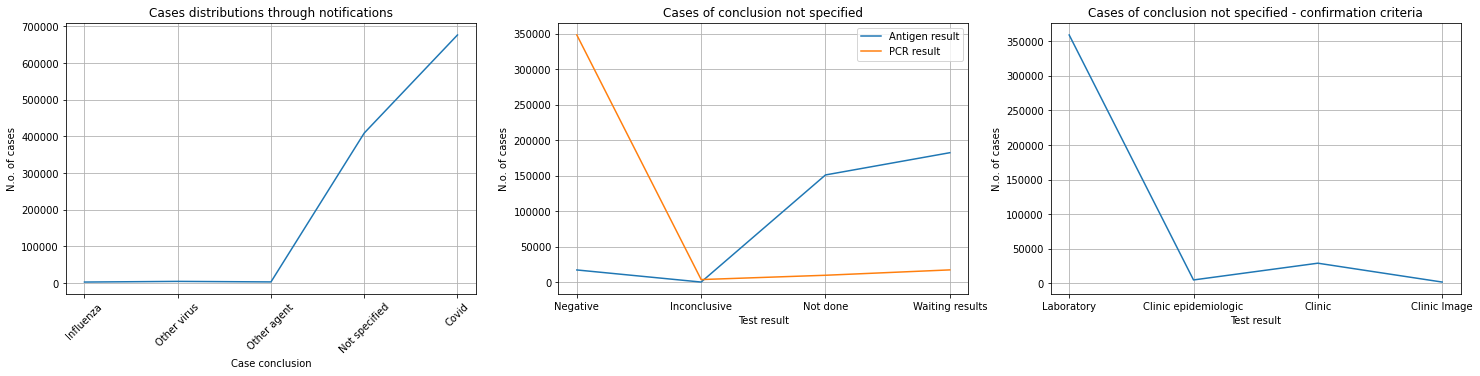

Diagnose not specified: 409097 cases.

Diagnose not specified and PCR result negative: 348060 cases.

Diagnose not specified and PCR result inconclusive: 3598 cases.

Diagnose not specified and PCR not done: 9660 cases.

Diagnose not specified and waiting PCR result: 17220 cases.

Diagnose not specified and antigen result negative: 17133 cases.

Diagnose not specified and antigen result inconclusive: 85 cases.

Diagnose not specified and antigen not done: 150936 cases.

Diagnose not specified and waiting antigen result: 182250 cases.



In [ ]:
#The data description use 9 to represent ignored and will be  removed.
#The number 2 means negative, so it will be kept.

dados.replace(9,np.nan,inplace=True)

#Graphs to explain the composition of diagnise group - not specified
plt.figure(figsize=(25,5))
plt.subplot(1,3,1)
plt.plot(dados.groupby('CLASSI_FIN')['CLASSI_FIN'].count())
plt.xticks([1,2,3,4,5],['Influenza','Other virus',
                        'Other agent','Not specified','Covid'])
plt.grid(axis='both')
plt.xticks(rotation=45)
plt.title('Cases distributions through notifications')
plt.xlabel('Case conclusion')
plt.ylabel('N.o. of cases')
plt.subplot(1,3,2)
plt.plot(dados[(dados.CLASSI_FIN==4)].groupby('RES_AN').\
         RES_AN.count())
plt.plot(dados[(dados.CLASSI_FIN==4)].groupby('PCR_RESUL').\
         PCR_RESUL.count())
plt.xticks([2,3,4,5],['Negative','Inconclusive','Not done','Waiting results'])
plt.legend(['Antigen result','PCR result'])
plt.title('Cases of conclusion not specified')
plt.xlabel('Test result')
plt.ylabel('N.o. of cases')
plt.grid(axis='both')
plt.subplot(1,3,3)
plt.plot(dados[(dados.CLASSI_FIN==4)].\
         groupby('CRITERIO').CRITERIO.count())
plt.xticks([1,2,3,4],['Laboratory','Clinic epidemiologic',
                      'Clinic','Clinic Image'])
plt.title('Cases of conclusion not specified - confirmation criteria')
plt.xlabel('Test result')
plt.ylabel('N.o. of cases')
plt.grid(axis='both')
plt.show()

ToPrint1=int(dados[(dados.CLASSI_FIN==4)].groupby('CLASSI_FIN').CLASSI_FIN.count())
ToPrint2,ToPrint3,ToPrint4,ToPrint5=dados[(dados.CLASSI_FIN==4)].groupby('PCR_RESUL').CLASSI_FIN.count()
ToPrint6,ToPrint7,ToPrint8,ToPrint9=dados[(dados.CLASSI_FIN==4)].groupby('RES_AN').CLASSI_FIN.count()

print('Diagnose not specified: {} cases.\n'.format(ToPrint1))
print('Diagnose not specified and PCR result negative: {} cases.\n'.\
      format(ToPrint2))
print('Diagnose not specified and PCR result inconclusive: {} cases.\n'.\
      format(ToPrint3))
print('Diagnose not specified and PCR not done: {} cases.\n'.format(ToPrint4))
print('Diagnose not specified and waiting PCR result: {} cases.\n'.\
      format(ToPrint5))
print('Diagnose not specified and antigen result negative: {} cases.\n'.\
      format(ToPrint6))
print('Diagnose not specified and antigen result inconclusive: {} cases.\n'.\
      format(ToPrint7))
print('Diagnose not specified and antigen not done: {} cases.\n'.\
      format(ToPrint8))
print('Diagnose not specified and waiting antigen result: {} cases.\n'.\
      format(ToPrint9))


Looking for notifications grouped by states. In the first graph, the absolute number of notifications, in the second the proportion between Covid cases per number of notifications and in the third graph, the proportion of Covid deaths in relation to infected patients. 

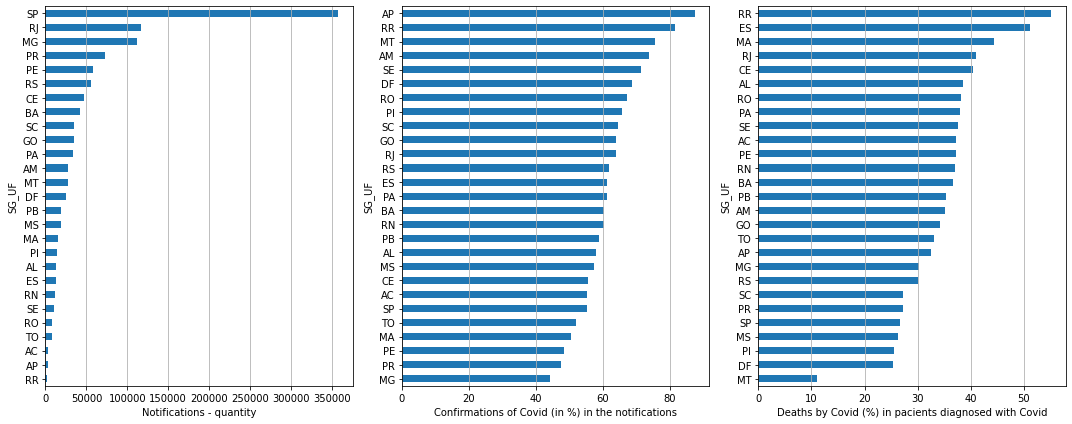

In [ ]:
#States total
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
dados.groupby('SG_UF').DT_NOTIFIC.count().\
           sort_values(ascending=True).plot.barh()
plt.xlabel('Notifications - quantity')
plt.grid(axis='x')
plt.tight_layout()

#Ranking states by COVID lethality
plt.subplot(1,3,2)
covid_notification=dados[(dados.CLASSI_FIN==5)].groupby('SG_UF').DT_NOTIFIC.count()
notification=dados.groupby('SG_UF').DT_NOTIFIC.count()
(100*covid_notification/notification).sort_values().plot.barh()
plt.xlabel('Confirmations of Covid (in %) in the notifications')
plt.grid(axis='x')

plt.subplot(1,3,3)
covid_death=dados[(dados.EVOLUCAO==2) & (dados.CLASSI_FIN==5) ].\
        groupby('SG_UF').DT_NOTIFIC.count()
(100*covid_death/covid_notification).sort_values().plot.barh()
plt.xlabel('Deaths by Covid (%) in pacients diagnosed with Covid')
plt.grid(axis='x')

plt.tight_layout()
plt.show()

## 4 - Answering the questions

Acording to the Health department the most frequent symptoms of COVID-19 are (https://coronavirus.saude.gov.br/sobre-a-doenca):
* cough (Tosse),
* fever (Febre),
* coryza (Coriza),
* sore throat,
* loss of smell, anosmia (Perd_OLFT),
* change in taste (Perd_PALA),
* gastrointestinal disorders (vomiting (VOMITO), diarrhea (DIARREIA), nausea),
* tiredness, asthenia (FADIGA),
* decreased appetite,
* dyspnoea, shortness of breath (DISPNEIA)

The symptoms in the data add those:
* Head pain (DOR_CABECA),
* Body pain (DOR_CORPO),
* Abdominal pain (DOR_ABD),
* O<sub>2</sub> saturation < 95% (SATURACAO),
* Unconfortable during respiration (DESC_RESP),
* Other symptoms (OUTROS_SIN)

Now, looking in the data for the related symptoms:

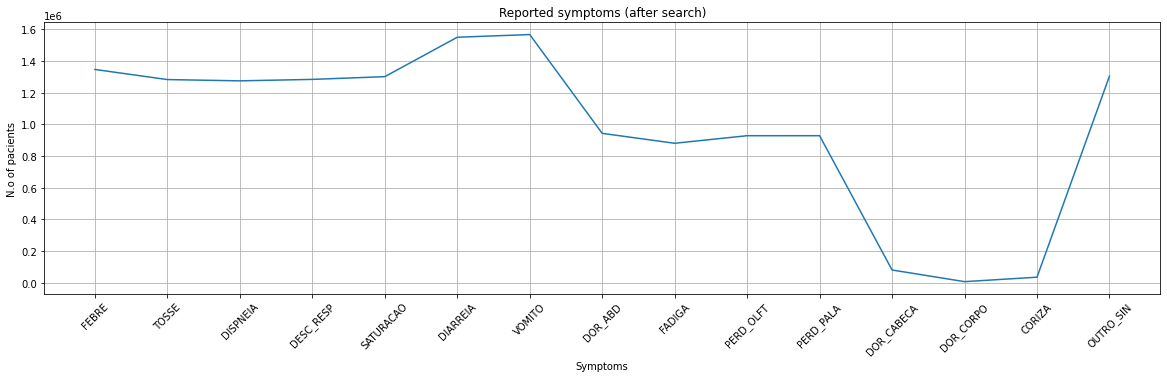

In [ ]:

plt.figure(figsize=(20,5))
plt.plot(dados[symptoms.keys()].sum())
plt.xticks(rotation=45)
plt.ylabel('N.o of pacients')
plt.xlabel('Symptoms')
plt.title('Reported symptoms (after search)')
plt.grid(axis='both')
plt.show()


### 4.1 - Is Covid more easily detectable in patients with pre-existing diseases? Is Covid more easily detectable in patients with pre-existing diseases?

Analyzing the correlation between symptoms and pre-existing diseases for the identification of Covid.

Number of notifications: 1181227
Number of Covid notifications: 676621
                       0
FEBRE_1.0       0.098091
TOSSE_1.0       0.063714
DISPNEIA_1.0    0.024801
DESC_RESP_1.0  -0.011695
SATURACAO_1.0   0.048731
DIARREIA_1.0    0.043363
VOMITO_1.0     -0.039734
DOR_ABD_1.0    -0.012050
FADIGA_1.0      0.065923
PERD_OLFT_1.0   0.099886
PERD_PALA_1.0   0.100575
DOR_CABECA_1.0  0.063443
DOR_CORPO_1.0   0.016197
CORIZA_1.0     -0.017785
OUTRO_SIN_1.0   0.059212
PUERPERA_1.0   -0.017893
CARDIOPATI_1.0  0.077414
HEMATOLOGI_1.0 -0.019149
SIND_DOWN_1.0  -0.010576
HEPATICA_1.0   -0.015186
ASMA_1.0       -0.067568
DIABETES_1.0    0.072447
NEUROLOGIC_1.0 -0.049856
PNEUMOPATI_1.0 -0.064453
IMUNODEPRE_1.0 -0.039271
RENAL_1.0      -0.007568
OBESIDADE_1.0   0.069959
OUT_MORBI_1.0   0.003001


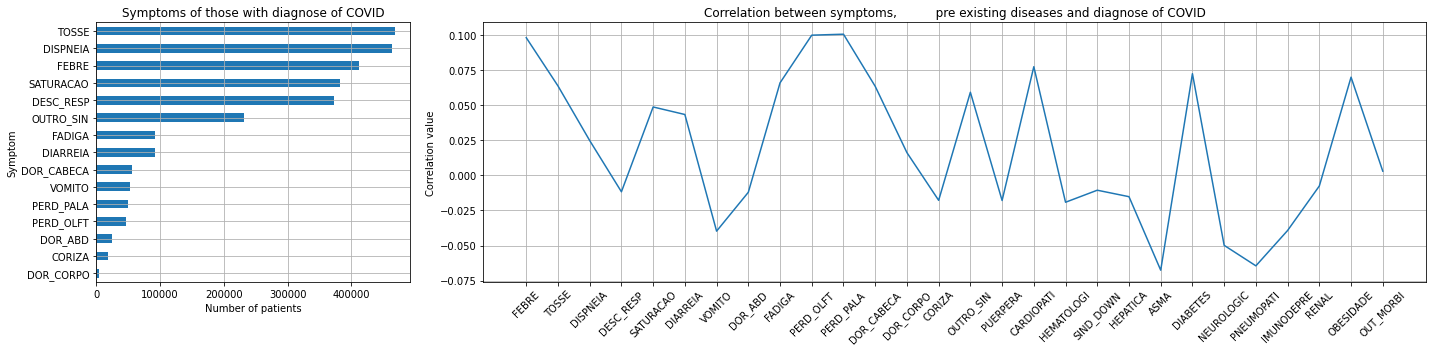

In [ ]:
#Aplying  encoding on some informations only
att_corr=list(symptoms.keys())+list(comorbidity.keys())+list(['CLASSI_FIN'])
corr_df=dados[att_corr].copy()
corr_df.loc[:,list(symptoms.keys())+list(comorbidity.keys())].\
           replace(2,np.nan, inplace=True) 
corr_df=pd.get_dummies(corr_df,columns=att_corr)


for num,att in enumerate(att_corr):
    att_corr[num]=att+('_1.0')
att_corr.remove('CLASSI_FIN_1.0')
corr_series=corr_df[att_corr].corrwith(corr_df['CLASSI_FIN_5.0']) 
fig=plt.figure(figsize=(20,5))
grid=gridspec.GridSpec(1,2,width_ratios=[1,3])

att_corr=list(symptoms.keys())
sum_sin=dados[dados.CLASSI_FIN==5][att_corr].copy()
sum_sin.replace(2,np.nan,inplace=True)
plt.subplot(grid[0])
ax0=sum_sin.sum().sort_values().plot.barh()
plt.grid(axis='both')
plt.title('Symptoms of those with diagnose of COVID')
plt.xlabel('Number of patients')
plt.ylabel('Symptom')

plt.subplot(grid[1])
ax1=plt.plot(corr_series.values.tolist())
plt.title('Correlation between symptoms, \
         pre existing diseases and diagnose of COVID')
plt.ylabel('Correlation value')
plt.xticks(np.arange(0,corr_series.shape[0]),
           labels=list(symptoms.keys())+list(comorbidity.keys()))
plt.xticks(rotation=45)
plt.grid(axis='both')

plt.tight_layout()
print('Number of notifications: {}\nNumber of Covid notifications: {}'.\
      format(dados.shape[0],covid_notification.sum()))


print(pd.DataFrame(corr_series))

del(att_corr,corr_df,corr_series,sum_sin)

Pretending to be a doctor, I correlated the symptoms and pre existent diseases with Covid's diagnosis. Therefore, a correlation test applied between those variable should approximate how good this assumption is. The graph of this correlation is shown in figure 5 and shows low correlation values with a maximum of almost 10%. In summary: it is difficult to predict Covid-19 cases based on symptoms alone. When a person have a disease the diagnose is difficult either.

###4.2 - What is the accuracy and recall of antigen, sorologic and PCR tests
To enhance and improve early diagnosis of Covid-19, antigen, sorology and PCR tests are disseminated over brazilian states (fig. 7)	. Just to compare with the first question we repeat the correlation test but now between the tests results and Covid diagnose. We show in the next graph the correlation between these tests and the confirmed Covid-19 cases.

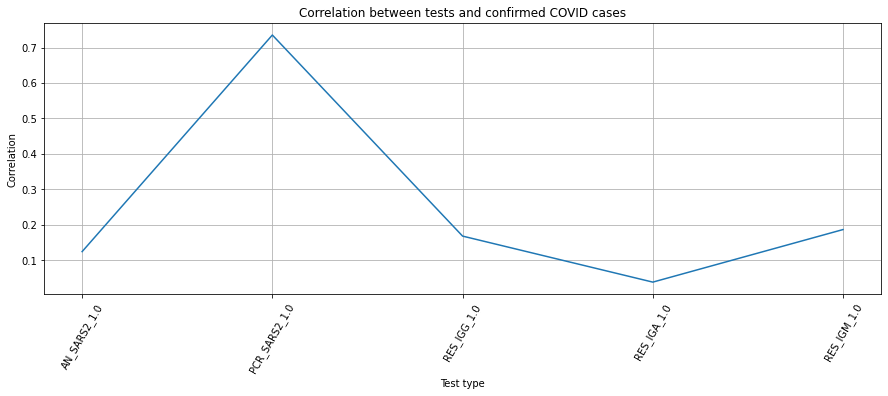

Correlation between tests (antigen, sorologic and PCR) and diagnose of COVID:


AN_SARS2_1.0     0.123665
PCR_SARS2_1.0    0.735359
RES_IGG_1.0      0.167497
RES_IGA_1.0      0.037524
RES_IGM_1.0      0.185956
dtype: float64

In [ ]:
#Is there a better COVID identification test?
#Aplying  encoding on some informations only
att_corr=list(['RES_AN','AN_SARS2','PCR_RESUL','PCR_SARS2',
              'RES_IGG','RES_IGA','RES_IGM','CLASSI_FIN'])
corr_df=dados[att_corr].copy()
corr_df=pd.get_dummies(corr_df,columns=att_corr)

#Removing columns without COVID final calssification
corr_df.drop(columns=['CLASSI_FIN_1.0','CLASSI_FIN_2.0',
                     'CLASSI_FIN_3.0','CLASSI_FIN_4.0'],
            inplace=True)

#Removing columns which don't detect COVID (test result negative to COVID or 
# detect other viruses)
corr_df.drop(columns=['RES_AN_1.0', 'RES_AN_2.0', 'RES_AN_3.0', 'RES_AN_4.0',
                      'RES_AN_5.0', 'PCR_RESUL_1.0', 'PCR_RESUL_2.0', 
                      'PCR_RESUL_3.0', 'PCR_RESUL_4.0', 'PCR_RESUL_5.0',
                      'RES_IGG_2.0', 'RES_IGG_3.0','RES_IGG_4.0', 'RES_IGG_5.0',
                      'RES_IGA_2.0', 'RES_IGA_3.0','RES_IGA_4.0','RES_IGA_5.0',
                      'RES_IGM_2.0', 'RES_IGM_3.0','RES_IGM_4.0', 'RES_IGM_5.0'],
             inplace=True)

att_corr=corr_df.columns.tolist()

att_corr.remove('CLASSI_FIN_5.0')

corr_serie=corr_df[att_corr].corrwith(corr_df['CLASSI_FIN_5.0'])

plt.figure(figsize=(15,5))
plt.plot(corr_serie)
plt.xticks(np.arange(0,len(att_corr)),att_corr,rotation=60)
plt.grid(axis='both')
plt.title('Correlation between tests and confirmed COVID cases')
plt.xlabel('Test type')
plt.ylabel('Correlation')
plt.show()
print('Correlation between tests (antigen, sorologic and PCR) and diagnose of COVID:')
display(corr_serie)


del(att_corr,corr_df,corr_serie)


According the dictionary to the database the identification of Covid should appear in fields AN_SARS2 = 1, PCR_SARS2 = 1, RES_IGG = 1, RES_IGA = 1 and RES_IGC = 1.

The positive PCR result with Covid identification (PCR_SARS2_1.0) has the highest correlation values. The surprise is the low correlation with a positive antigen test (AN_SARS2_1.0) to Covid identification. The low correlation of IGG, IGA and IGM was observed to.

In [ ]:
#False positive of antigenic test (excluding 4-not done, 5-Waiting e 9-Ignored)
false_pos_ant=dados[(dados.CLASSI_FIN!=5) & (dados.AN_SARS2 == 1) ]\
                    [['AN_SARS2','CLASSI_FIN']].groupby('CLASSI_FIN').count().\
                    sum().values

#False positive of PCR test (excluding 4-not done, 5-Waiting e 9-Ignored)
false_pos_pcr=dados[(dados.CLASSI_FIN!=5) & (dados.PCR_SARS2 == 1)]\
                    [['PCR_SARS2','CLASSI_FIN']].groupby('CLASSI_FIN').count().\
                    sum().values

#False positive of sorologic test (excluding 4-not done, 5-Waiting e 9-Ignored)
false_pos_soro=dados[(dados.CLASSI_FIN!=5) & ((dados.RES_IGG == 1) | \
                                             (dados.RES_IGA == 1) | \
                                             (dados.RES_IGM == 1))]\
                    [['RES_IGG','RES_IGM','RES_IGA','CLASSI_FIN']].\
                    groupby('CLASSI_FIN').count().sum().sum()

print('False positive cases pcr test: ',false_pos_pcr)
print('False positive cases antigenic test: ',false_pos_ant)
print('False positive cases sorologic test: ',false_pos_soro)

False positive cases pcr test:  PCR_SARS2    57
dtype: int64
False positive cases antigenic test:  AN_SARS2    137
dtype: int64
False positive cases sorologic test:  3321


And answering the question the precision and recall for both tests are displayed in table bellow.

In [ ]:
#PCR positive to COVID and Covid diagnosis - CLASSI_FIN=5 - COVID diagnosis
true_pos_pcr=dados[(dados.PCR_SARS2==1)&(dados.CLASSI_FIN==5)].\
             DT_NOTIFIC.count()
false_pos_pcr=dados[(dados.PCR_SARS2==1)&(dados.CLASSI_FIN!=5)].\
              DT_NOTIFIC.count()
# PCR_RES=1->Detectable PCR_RES=2->not Detectable PCR_SARS2=NaN - isn't COVID
true_neg_pcr=dados[((dados.PCR_RESUL==1)|(dados.PCR_RESUL==2)) & (dados.PCR_SARS2.isna()) & \
                     (dados.CLASSI_FIN!=5)].DT_NOTIFIC.count()
false_neg_pcr=dados[((dados.PCR_RESUL==1)|(dados.PCR_RESUL==2)) & (dados.PCR_SARS2.isna()) & \
                       (dados.CLASSI_FIN==5)].DT_NOTIFIC.count()

#Antigenic
true_pos_ant=dados[(dados.AN_SARS2==1)&(dados.CLASSI_FIN==5)].\
           DT_NOTIFIC.count()
false_pos_ant=dados[(dados.AN_SARS2==1)&(dados.CLASSI_FIN!=5)].\
            DT_NOTIFIC.count()
# RES_AN=1->Positive RES_AN=2->Negative AN_SARS2=NaN - isn't COVID
true_neg_ant=dados[((dados.RES_AN==1)&(dados.AN_SARS2.isna())&(dados.CLASSI_FIN!=5))|\
                   ((dados.RES_AN==2)&(dados.CLASSI_FIN!=5))\
                    ].DT_NOTIFIC.count()
false_neg_ant=dados[((dados.RES_AN==1)&(dados.AN_SARS2.isna())&(dados.CLASSI_FIN==5))|\
                   ((dados.RES_AN==2)&(dados.CLASSI_FIN==5))\
                    ].DT_NOTIFIC.count()

#Sorologic
#RES_IGX=1 Covid diagnose
true_pos_soro=dados[((dados.RES_IGG==1)|(dados.RES_IGM==1)|\
                         (dados.RES_IGA==1))& (dados.CLASSI_FIN==5)].\
                         DT_NOTIFIC.count()
false_pos_soro=dados[((dados.RES_IGG==1)|(dados.RES_IGM==1)|\
                         (dados.RES_IGA==1))& (dados.CLASSI_FIN!=5)].\
                         DT_NOTIFIC.count()
#RES_IGX=2 Covid diagnose negative
true_neg_soro=dados[((dados.RES_IGG==2)|(dados.RES_IGM==2)|\
                         (dados.RES_IGA==2))& (dados.CLASSI_FIN!=5)].\
                         DT_NOTIFIC.count()
false_neg_soro=dados[((dados.RES_IGG==2)|(dados.RES_IGM==2)|\
                         (dados.RES_IGA==2))& (dados.CLASSI_FIN==5)].\
                         DT_NOTIFIC.count()

#Calculation of Precision and Recall - PCR
precision_pcr=true_pos_pcr/(true_pos_pcr+false_pos_pcr)
recall_pcr=true_pos_pcr/(true_pos_pcr+false_neg_pcr)

#Calculation of Precision and Recall - Antigenic
precision_ant=true_pos_ant/(true_pos_ant+false_pos_ant)
recall_ant=true_pos_ant/(true_pos_ant+false_neg_ant)

#Calculation of Precision and Recall - Sorologic
precision_soro=true_pos_soro/(true_pos_soro+false_pos_soro)
recall_soro=true_pos_soro/(true_pos_soro+false_neg_soro)

#Comparing Precision and Recall to PCR, Antigenic and Sorologic
print('Precision {0:5.2f} and Recall {1:5.2f} - PCR test'.\
      format(precision_pcr,recall_pcr))
print('Precision {0:5.2f} and Recall {1:5.2f} - Antigen test'.\
      format(precision_ant,recall_ant))
print('Precision {0:5.2f} and Recall {1:5.2f} - Sorologic test'.\
      format(precision_soro,recall_soro))

print(true_pos_pcr,false_pos_pcr,true_neg_pcr,false_neg_pcr)
print(true_pos_ant,false_pos_ant,true_neg_ant,false_neg_ant)
print(true_pos_soro,false_pos_soro,true_neg_soro,false_neg_soro)


Precision  1.00 and Recall  0.88 - PCR test
Precision  0.99 and Recall  0.44 - Antigen test
Precision  0.96 and Recall  0.73 - Sorologic test
497023 281 367287 65432
25042 371 19574 31501
69407 2668 21638 25733


##4.3 - Are these metrics (accuracy and recall) the same in the Brazilian states?
Before repeating the previous analysis is possible to track how is distribution of tests applied over brazilian states. The results are displayed in figure 8 and we can confirm that Brazilian states are using PCR test in majority, except Amapá-AP (according to this data set).

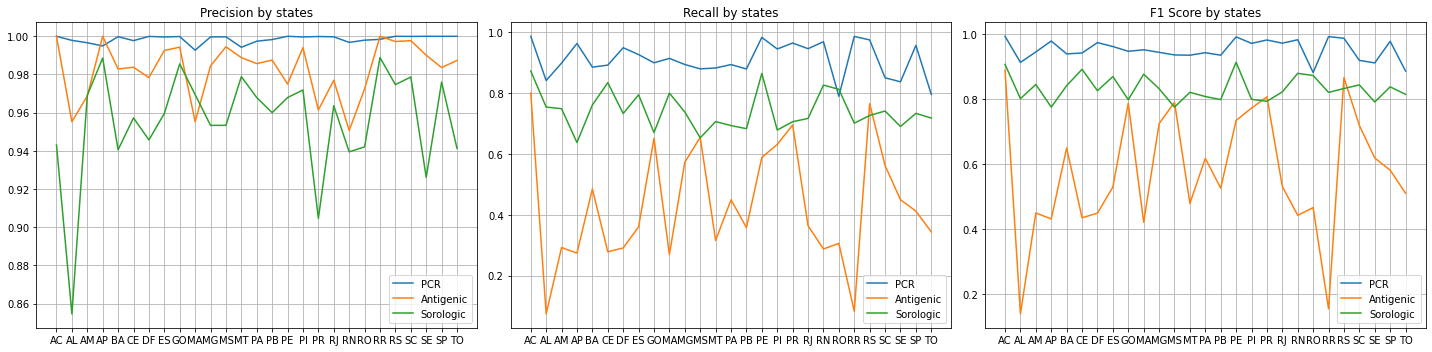

In [ ]:
#PCR positive to COVID and Covid diagnosis 
true_pos_pcr=dados[(dados.PCR_SARS2==1)&(dados.CLASSI_FIN==5)].\
             groupby('SG_UF').DT_NOTIFIC.count()
false_pos_pcr=dados[(dados.PCR_SARS2==1)&(dados.CLASSI_FIN!=5)].\
              groupby('SG_UF').DT_NOTIFIC.count()
true_neg_pcr=dados[(dados.PCR_RESUL==1) & (dados.PCR_SARS2.isna()) & \
                     (dados.CLASSI_FIN!=5)].groupby('SG_UF').DT_NOTIFIC.count()
false_neg_pcr=dados[(dados.PCR_RESUL==1) & (dados.PCR_SARS2.isna()) & \
                       (dados.CLASSI_FIN==5)].groupby('SG_UF').DT_NOTIFIC.count()

#Antigenic
true_pos_ant=dados[(dados.AN_SARS2==1)&(dados.CLASSI_FIN==5)].\
           groupby('SG_UF').DT_NOTIFIC.count()
false_pos_ant=dados[(dados.AN_SARS2==1)&(dados.CLASSI_FIN!=5)].\
            groupby('SG_UF').DT_NOTIFIC.count()
true_neg_ant=dados[((dados.RES_AN==1)&(dados.AN_SARS2.isna())&(dados.CLASSI_FIN!=5))|\
                   ((dados.RES_AN==2)&(dados.CLASSI_FIN!=5))\
                    ].groupby('SG_UF').DT_NOTIFIC.count()
false_neg_ant=dados[((dados.RES_AN==1)&(dados.AN_SARS2.isna())&(dados.CLASSI_FIN==5))|\
                   ((dados.RES_AN==2)&(dados.CLASSI_FIN==5))\
                    ].groupby('SG_UF').DT_NOTIFIC.count()

#Sorologic
true_pos_soro=dados[((dados.RES_IGG==1)|(dados.RES_IGM==1)|\
                         (dados.RES_IGA==1))& (dados.CLASSI_FIN==5)].\
                         groupby('SG_UF').DT_NOTIFIC.count()
false_pos_soro=dados[((dados.RES_IGG==1)|(dados.RES_IGM==1)|\
                         (dados.RES_IGA==1))& (dados.CLASSI_FIN!=5)].\
                         groupby('SG_UF').DT_NOTIFIC.count()
true_neg_soro=dados[((dados.RES_IGG==2)|(dados.RES_IGM==2)|\
                         (dados.RES_IGA==2))& (dados.CLASSI_FIN!=5)].\
                         groupby('SG_UF').DT_NOTIFIC.count()
false_neg_soro=dados[((dados.RES_IGG==2)|(dados.RES_IGM==2)|\
                         (dados.RES_IGA==2))& (dados.CLASSI_FIN==5)].\
                         groupby('SG_UF').DT_NOTIFIC.count()

#Series to combine and obtain results by state
Combine=pd.Series(np.zeros(27),index=dados[~dados.SG_UF.isna()].\
                  SG_UF.unique())

#Calculation of Precision and Recall - PCR - by state
Precision_PCR=true_pos_pcr/(true_pos_pcr+false_pos_pcr.\
                          combine(Combine,max,fill_value=0))
Recall_PCR=true_pos_pcr/(true_pos_pcr+false_neg_pcr.\
                       combine(Combine,max,fill_value=0))

#Calculation of Precision and Recall - Antígeno - by state
Precision_Ant=true_pos_ant/(true_pos_ant+false_pos_ant.\
                          combine(Combine,max,fill_value=0))
Recall_Ant=true_pos_ant/(true_pos_ant+false_neg_ant.\
                       combine(Combine,max,fill_value=0))

#Calculation of Precision and Recall - Sorologic - by state
Precision_soro=true_pos_soro/(true_pos_soro+false_pos_soro.\
                          combine(Combine,max,fill_value=0))
Recall_soro=true_pos_soro/(true_pos_soro+false_neg_soro.\
                       combine(Combine,max,fill_value=0))

states=dados.SG_UF.dropna().unique().tolist()

plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(Precision_PCR[~Precision_PCR.isna()])
plt.plot(Precision_Ant[~Precision_Ant.isna()])
plt.plot(Precision_soro[~Precision_soro.isna()])
plt.legend(['PCR','Antigenic','Sorologic'])
plt.grid(axis='both')
plt.title('Precision by states')
plt.subplot(1,3,2)
plt.plot(Recall_PCR[~Recall_PCR.isna()])
plt.plot(Recall_Ant[~Recall_Ant.isna()])
plt.plot(Recall_soro[~Recall_soro.isna()])
plt.legend(['PCR','Antigenic','Sorologic'])
plt.grid(axis='both')
plt.title('Recall by states')
plt.subplot(1,3,3)
plt.plot(2*Precision_PCR*Recall_PCR/(Precision_PCR+Recall_PCR))
plt.plot(2*Precision_Ant*Recall_Ant/(Precision_Ant+Recall_Ant).\
         combine(Combine,max,fill_value=0))
plt.plot(2*Precision_soro*Recall_soro/(Precision_soro+Recall_soro))
plt.legend(['PCR','Antigenic','Sorologic'])
plt.grid(axis='both')
plt.title('F1 Score by states')

plt.tight_layout()
plt.show()

###5 - Conclusions
All data presented in this trial are free and open access. Could a 
hackathon, perhaps, be the next step for the health agency? Regarding the 
database, some information are not conclusive, such as the high number of cases 
with an undefined diagnosis and records waiting for the exam result.
       We found a lot of information in the description fields, including 
symptoms like headache, muscle pain and runny nose, which were included as fields.
       We were also able to highlight the differences in accuracy and recall 
of the results of the applications of antigenic, serological and PCR tests 
between Brazilian states.
       The same problem analyzed by correlation or accuracy and recall can 
lead to different interpretations. In this specific case, both point to the use 
of tests to identify Covid's infection.